## Perturbative footprint study: data creation

### Imports

In [11]:
# Standard imports
import numpy as np
import shutil
from ruamel.yaml import YAML
import os
import matplotlib.pyplot as plt
import pickle
import subprocess
import time
#from multiprocessing import Pool
#from multiprocessing.dummy import Pool as ThreadPool

# Cern modules
import fillingpatterns as fp
import xtrack as xt

# Improve style
import seaborn as sns

sns.set_theme(style="whitegrid")

### Generate a machine with xmask from the appropriate configuration file

#### First create a proper configuration file

In [12]:
# Copy default configuration file for xmask, and target configuration file for pymask
shutil.copyfile("../modules/xmask/examples/hllhc15_collision/config.yaml", "config_xm.yaml")
shutil.copyfile(
    "/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches/madx_001/config.yaml",
    "config_pm.yaml",
)


# Read and mutate xmask config file
with open("config_xm.yaml", "r") as fid:
    config_xm_str = fid.read()

with open("config_pm.yaml", "r") as fid:
    config_pm_str = fid.read()

yaml = YAML()
config_pm = yaml.load(config_pm_str)
config_xm = yaml.load(config_xm_str)

# Hardcode optics configuration files as they can't be ported directly
config_xm["config_mad"]["links"]["acc-models-lhc"] = "/afs/cern.ch/eng/lhc/optics/HLLHCV1.5"
config_xm["config_mad"]["optics_file"] = "acc-models-lhc/flatcc/opt_flathv_75_180_1500_thin.madx"
config_xm["config_knobs_and_tuning"]["closed_orbit_correction"][
    "lhcb1"
] = "../modules/tools/corr_co_lhcb1.json"
config_xm["config_knobs_and_tuning"]["closed_orbit_correction"][
    "lhcb2"
] = "../modules/tools/corr_co_lhcb2.json"

# Mutate optics and check config
config_xm["config_mad"]["enable_imperfections"] = config_pm["enable_imperfections"]
config_xm["config_mad"]["enable_knob_synthesis"] = config_pm["enable_knob_synthesis"]
config_xm["config_mad"]["ver_hllhc_optics"] = float(config_pm["optics_version"])
config_xm["config_mad"]["pars_for_imperfections"] = config_pm["pars_for_imperfections"]

# Mutate beam config
config_xm["config_mad"]["beam_config"]["lhcb1"]["beam_energy_tot"] = config_pm["beam_energy_tot"]
config_xm["config_mad"]["beam_config"]["lhcb2"]["beam_energy_tot"] = config_pm["beam_energy_tot"]

# Mutate beambeam parameters
config_xm["config_beambeam"]["nemitt_x"] = config_pm["beam_norm_emit_x"] * 1e-6
config_xm["config_beambeam"]["nemitt_y"] = config_pm["beam_norm_emit_y"] * 1e-6
config_xm["config_beambeam"]["sigma_z"] = config_pm["beam_sigt"]
config_xm["config_beambeam"]["num_particles_per_bunch"] = config_pm["beam_npart"]
config_xm["config_beambeam"]["num_particles_per_bunch"] = config_pm["beam_npart"]
for i, ip in enumerate(["ip1", "ip2", "ip5", "ip8"]):
    config_xm["config_beambeam"]["num_long_range_encounters_per_side"][ip] = config_pm[
        "beambeam_config"
    ]["numberOfLRPerIRSide"][i]
config_xm["config_beambeam"]["num_slices_head_on"] = config_pm["beambeam_config"][
    "numberOfHOSlices"
]
config_xm["config_beambeam"]["bunch_spacing_buckets"] = config_pm["beambeam_config"][
    "bunch_spacing_buckets"
]

# Mutate tunes and chromaticities (assume same for both beams, since not settable in pymask)
config_xm["config_knobs_and_tuning"]["qx"]["lhcb1"] = config_pm["qx0"]
config_xm["config_knobs_and_tuning"]["qx"]["lhcb2"] = config_pm["qx0"]
config_xm["config_knobs_and_tuning"]["qy"]["lhcb1"] = config_pm["qy0"]
config_xm["config_knobs_and_tuning"]["qy"]["lhcb2"] = config_pm["qy0"]
config_xm["config_knobs_and_tuning"]["dqx"]["lhcb1"] = config_pm["chromaticity_x"]
config_xm["config_knobs_and_tuning"]["dqx"]["lhcb2"] = config_pm["chromaticity_x"]
config_xm["config_knobs_and_tuning"]["dqy"]["lhcb1"] = config_pm["chromaticity_y"]
config_xm["config_knobs_and_tuning"]["dqy"]["lhcb2"] = config_pm["chromaticity_y"]

# Mutate knobs
for knob in config_pm["knob_settings"]:
    if knob in config_xm["config_knobs_and_tuning"]["knob_settings"]:
        config_xm["config_knobs_and_tuning"]["knob_settings"][knob] = config_pm["knob_settings"][
            knob
        ]
    else:
        print(f"Knob {knob} not found in xmask config file. Beind added now.")
        config_xm["config_knobs_and_tuning"]["knob_settings"][knob] = config_pm["knob_settings"][
            knob
        ]

# Mutate RF voltage and octupole current
config_xm["config_knobs_and_tuning"]["knob_settings"]["vrf400"] = config_pm["vrf_total"]
config_xm["config_knobs_and_tuning"]["knob_settings"]["i_oct_b1"] = config_pm["oct_current"]
config_xm["config_knobs_and_tuning"]["knob_settings"]["i_oct_b2"] = config_pm["oct_current"]


# Artificially implement end of luminosity levelling
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep8"] = 0.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep8h"] = -0.01745641501719127
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep8v"] = 0.01371863979152592
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_x8"] = 0.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_x8h"] = 0.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_x8v"] = 170.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep2"] = 0.1443593672910653


# ! WARNING. AT THIS POINT:
# ! - Coupling is missing
# ! - bunch-by-bunch and filling schemes are missing


# Write config file
with open("config_xm.yaml", "w") as fid:
    yaml.dump(config_xm, fid)

Done computing footprint.
Knob on_x8h not found in xmask config file. Beind added now.
Knob on_x8v not found in xmask config file. Beind added now.
Knob on_sep8h not found in xmask config file. Beind added now.
Knob on_sep8v not found in xmask config file. Beind added now.


#### Build machine

In [13]:
REBUILD = False
if REBUILD:
    os.system("python build_machine.py")
collider = xt.Multiline.from_json("output/collider_tuned_bb_on.json")
collider.build_trackers()

Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 65%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.9%  
Done tracking.rom dict: 30%  
Computing footprint...
Done computing footprint.6%  
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


dd93bad3e21f48d5b73d7ce59c5683b5.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from dd93bad3e21f48d5b73d7ce59c5683b5.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done tracking.
Computing footprint...
Done computing footprint.
Done tracking.
Computing footprint...
Done computing footprint.
Done tracking.
Computing footprint...
Done computing footprint.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


64b346b886874b1198f6ac74d6dbced7.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 64b346b886874b1198f6ac74d6dbced7.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done tracking.
Computing footprint...
Done computing footprint.
Done tracking.
Computing footprint...
Done computing footprint.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done tracking.
Computing footprint...
Done compiling ContextCpu kernels.
Done computing footprint.
Compiling ContextCpu kernels...
Done tracking.
Computing footprint...
Done computing footprint.
Done compiling ContextCpu kernels.


### Correct bbb schedule

In [14]:
# Get BB schedule
fname = "filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.json"
patt = fp.FillingPattern.from_json(fname)

# Compute bb schedule
patt.compute_beam_beam_schedule(n_lr_per_side=25)
bbs_b1 = patt.b1.bb_schedule
bbs_b2 = patt.b2.bb_schedule

# Get list of bunches
bbs_b1

Computing collision schedules...
Done tracking.
Computing footprint...
Done Beam 1
Done computing footprint.
Done Beam 2


,HO partner in ALICE,# of LR in ALICE,BB partners in ALICE,Positions in ALICE,HO partner in ATLAS/CMS,# of LR in ATLAS/CMS,BB partners in ATLAS/CMS,Positions in ATLAS/CMS,HO partner in LHCB,# of LR in LHCB,BB partners in LHCB,Positions in LHCB,collides in ATLAS/CMS,collides in ALICE,collides in LHCB
12,903.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",2682.0,29,"[2657.0, 2658.0, 2659.0, 2660.0, 2661.0, 2662....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",False,True,True
13,904.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",2683.0,28,"[2658.0, 2659.0, 2660.0, 2661.0, 2662.0, 2667....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",False,True,True
14,905.0,22,"[880.0, 881.0, 882.0, 883.0, 884.0, 885.0, 886...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",2684.0,27,"[2659.0, 2660.0, 2661.0, 2662.0, 2667.0, 2668....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",False,True,True
15,906.0,21,"[881.0, 882.0, 883.0, 884.0, 885.0, 886.0, 891...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",2685.0,26,"[2660.0, 2661.0, 2662.0, 2667.0, 2668.0, 2669....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",False,True,True
16,907.0,20,"[882.0, 883.0, 884.0, 885.0, 886.0, 891.0, 892...","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",2686.0,25,"[2661.0, 2662.0, 2667.0, 2668.0, 2669.0, 2670....","[-25.0, -24.0, -19.0, -18.0, -17.0, -16.0, -15...",False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,765.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",3438.0,21,"[3413.0, 3414.0, 3415.0, 3416.0, 3417.0, 3418....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",2544.0,21,"[2519.0, 2520.0, 2521.0, 2522.0, 2523.0, 2524....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",True,True,True
3439,766.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3439.0,20,"[3414.0, 3415.0, 3416.0, 3417.0, 3418.0, 3423....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",2545.0,20,"[2520.0, 2521.0, 2522.0, 2523.0, 2524.0, 2529....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",True,True,True
3440,767.0,22,"[742.0, 743.0, 744.0, 745.0, 746.0, 747.0, 748...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3440.0,19,"[3415.0, 3416.0, 3417.0, 3418.0, 3423.0, 3424....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",2546.0,19,"[2521.0, 2522.0, 2523.0, 2524.0, 2529.0, 2530....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",True,True,True
3441,768.0,21,"[743.0, 744.0, 745.0, 746.0, 747.0, 748.0, 753...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",3441.0,18,"[3416.0, 3417.0, 3418.0, 3423.0, 3424.0, 3425....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",2547.0,18,"[2522.0, 2523.0, 2524.0, 2529.0, 2530.0, 2531....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",True,True,True


In [15]:
def fix_bb_elements(collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False):
    # Reset collider
    if reset_collider:
        for i, x in enumerate(collider.lhcb1.element_names):
            if "bb_lr" in x or "bb_ho" in x:
                try:
                    collider.lhcb1.vars[x + '_scale_strength'] = collider.lhcb1.vars['beambeam_scale']
                    collider.lhcb1.element_refs[x].scale_strength = collider.lhcb1.vars[x + '_scale_strength']
                except Exception as e:
                    print(e)
                    print(f"Failed to reset {x}")
                    
                
        for i, x in enumerate(collider.lhcb2.element_names):
            if "bb_lr" in x or "bb_ho" in x:
                try:
                    collider.lhcb2.vars[x + '_scale_strength'] = collider.lhcb2.vars['beambeam_scale']
                    collider.lhcb2.element_refs[x].scale_strength = collider.lhcb2.vars[x + '_scale_strength']
                except Exception as e:
                    print(e)
                    print(f"Failed to reset {x}")

    # Take care of LR elements
    for ip, name_position in zip(
        [1, 2, 5, 8],
        [
            "Positions in ATLAS/CMS",
            "Positions in ALICE",
            "Positions in ATLAS/CMS",
            "Positions in LHCB",
        ],
    ):
        # Deactivate elements that shouldn't be here in beam 1
        idx_elements_b1 = bbs_b1.loc[bunch_nb][name_position]
        for i, x in enumerate(collider.lhcb1.element_names):
            # print(collider.lhcb1[x].to_dict())
            # First look for bb_elements for current IP
            if "bb_lr.l" + str(ip) in x or "bb_lr.r" + str(ip) in x:
                # Then only keep elements corresponding to the current IP
                pos = int(x.split("_")[2])
                if "l" in x.split("lr.")[1]:
                    pos = -pos
                if pos not in idx_elements_b1:
                    collider.lhcb1.element_refs[x].scale_strength = 0

        # Same with beam 2
        if also_beam_2:
            idx_elements_b2 = bbs_b2.loc[bunch_nb][name_position]
            for i, x in enumerate(collider.lhcb2.element_names):
                if "bb_lr.l" + str(ip) in x or "bb_lr.r" + str(ip) in x:
                    pos = int(x.split("_")[2])
                    if "l" in x.split("lr.")[1]:
                        pos = -pos
                    if pos not in idx_elements_b2:
                        collider.lhcb2.vars[x + '_scale_strength'] = 0

    # Take care of HO elements
    for ip, bool_collide in zip(
        [1, 2, 5, 8],
        ["collides in ATLAS/CMS", "collides in ALICE", "collides in ATLAS/CMS", "collides in LHCB"],
    ):
        collide_b1 = bbs_b1.loc[bunch_nb][bool_collide]

        # Deactivate elements that shouldn't be here in beam 1
        for i, x in enumerate(collider.lhcb1.element_names):
            # First look for bb_elements
            if (
                "bb_ho.l" + str(ip) in x or "bb_ho.r" + str(ip) in x or "bb_ho.c" + str(ip) in x
            ) and not collide_b1:
                collider.lhcb1.element_refs[x].scale_strength = 0

        # Same with beam 2
        if also_beam_2:
            collide_b2 = bbs_b2.loc[bunch_nb][bool_collide]
            for i, x in enumerate(collider.lhcb2.element_names):
                if (
                    "bb_ho.l" + str(ip) in x or "bb_ho.r" + str(ip) in x or "bb_ho.c" + str(ip) in x
                ) and not collide_b2:
                    collider.lhcb2.vars[x + '_scale_strength'] = 0

    # Print final result
    if print_final_result:
        # Beam 1
        print("Beam 1")
        for i, x in enumerate(collider.lhcb1.element_names):
            if "bb_ho" in x or "bb_lr" in x:
                print(x, collider.lhcb1.element_refs[x].scale_strength._value)

        # Beam 2
        if also_beam_2:
            print("Beam 2")
            for i, x in enumerate(collider.lhcb2.element_names):
                if "bb_ho" in x or "bb_lr" in x:
                    print(x, collider.lhcb2.element_refs[x].scale_strength._value)

    # Return collider
    return collider

## Plot footprint for a given bunch

Coupling correction due to the lattice (```delta_cmr``` and ```delta_cmi``` in pymask) are ignored as they're not very relevant for the coupling study.

In [16]:
plot_evolution_with_nturns = False
if plot_evolution_with_nturns:
    bunch_nb = 23
    collider = fix_bb_elements(
        collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False
    )

    print('OK SO FAR')
    for n_turns in [100, 500, 1000, 5000, 20000]:
        # Plot footprint
        fp_polar_xm = collider["lhcb1"].get_footprint(
            nemitt_x=2.5e-6,
            nemitt_y=2.5e-6,
            n_turns=n_turns,
            linear_rescale_on_knobs=[
                xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1 / 2)
            ],
        )

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        fp_polar_xm.plot(ax=ax)
        ax.set_title(f"Footprint for {n_turns} turns")
        #plt.show()
        plt.savefig(f"output_2/footprint_xm_{n_turns}.png")

In [17]:
check_result_without_coupling = False
# Check result without coupling
if check_result_without_coupling:
    # Save values before changing anything
    c_minus_re_b1_before_correction = collider.vars["c_minus_re_b1"]._value
    c_minus_re_b2_before_correction = collider.vars["c_minus_re_b2"]._value
    c_minus_im_b1_before_correction = collider.vars["c_minus_im_b1"]._value
    c_minus_im_b2_before_correction = collider.vars["c_minus_im_b2"]._value

    # Set all couplings to zero
    collider.vars["c_minus_re_b1"] = 0
    collider.vars["c_minus_im_b1"] = 0
    collider.vars["c_minus_re_b2"] = 0
    collider.vars["c_minus_im_b2"] = 0

    # Twiss just to be safe
    collider["lhcb1"].twiss()
    collider["lhcb2"].twiss()

    # Plot footprint
    fp_polar_xm = collider["lhcb1"].get_footprint(
        nemitt_x=2.5e-6,
        nemitt_y=2.5e-6,
        n_turns=2000,
        linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1 / 2)],
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fp_polar_xm.plot(ax=ax, label="no rescale bb")
    plt.show()

    # Reset values
    collider.vars["c_minus_re_b1"] = c_minus_re_b1_before_correction
    collider.vars["c_minus_im_b1"] = c_minus_im_b1_before_correction
    collider.vars["c_minus_re_b2"] = c_minus_re_b2_before_correction
    collider.vars["c_minus_im_b2"] = c_minus_im_b2_before_correction

### Get footprint for all bunches

In [18]:
def return_footprint(collider, bunch_nb, n_turns):
    # Adapt collider for current bunch
    collider = fix_bb_elements(
        collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False
    )
    # Get footprint
    fp_polar_xm = collider["lhcb1"].get_footprint(
        nemitt_x=2.5e-6,
        nemitt_y=2.5e-6,
        n_turns=n_turns,
        linear_rescale_on_knobs=[
            xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.05)
        ],
    )

    return [fp_polar_xm.qx, fp_polar_xm.qy]

In [19]:
def run_footprint_in_parallel_scripts(collider, l_bunch_nb, n_turns, force_redo = False):
    wd = os.getcwd()

    # Build a temporary folder for each bunch number
    for bunch_nb in l_bunch_nb:

        # Ensure you're in workind directory
        os.chdir(wd)

        # If the job has already been done, skip it
        folder_name = f"output_2/{bunch_nb}"
        if os.path.exists(folder_name + '/fp_polar_xm.pkl') and not force_redo:
            print(f"Skipping bunch {bunch_nb}")
            continue

        # Create folder
        folder_name = f"output_2/{bunch_nb}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Adapt collider
        collider = fix_bb_elements(
            collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False
        )

        # Save collider as json
        collider.to_json(f"{folder_name}/collider_tuned_bb_on.json")

        # Build a file containing a python script in which I create collider and compute footprint
        with open(f"{folder_name}/footprint.py", "w") as f:
            f.write(f"""
import pickle
import xtrack as xt

# Load collider
collider = xt.Multiline.from_json(f"collider_tuned_bb_on.json")
collider.build_trackers()

# Compute footprint
fp_polar_xm = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    n_turns={n_turns},
    r_range = (0.01, 10.),
    n_r = 15,
    linear_rescale_on_knobs=[
        xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.04)
    ],
)

# Save footprint
with open(f"fp_polar_xm.pkl", "wb") as f:
    pickle.dump([fp_polar_xm.qx, fp_polar_xm.qy], f)
            """)
        
        # Move to the folder
        os.chdir(f"{folder_name}/")

        # Run script using subprocess
        subprocess.run(f"python footprint.py &", shell=True)

    # Move back to working directory
    os.chdir(wd)

In [20]:
l_bunch_nb =  list(bbs_b1.index)
n_turns = 2000

# Multiprocessing or multithreading in Python doesn't seem to work :'(
do_multiprocessing_in_notebook = False
if do_multiprocessing_in_notebook:
    pool = Pool(4)
    l_fp = [x for x in pool.starmap(return_footprint, [ (xt.Multiline.from_dict(collider.to_dict()), bunch_nb, n_turns) for bunch_nb in l_bunch_nb[:2]])]

# So I do multiprocessing through scripts
do_multiprocessing_in_script = True
if do_multiprocessing_in_script:
    size_series = 100
    for series in range(0, len(l_bunch_nb), size_series):
        print(f"Running series {series} to {series+size_series}")
        run_footprint_in_parallel_scripts(collider, l_bunch_nb[series:series+size_series], n_turns)
        # Check every 30 seconds if the last job of the series is done
        while not os.path.exists(f"output_2/{l_bunch_nb[series+size_series-1]}/fp_polar_xm.pkl"):
            time.sleep(30)



# Running jobs in series is way too slow   
else:
    l_fp = []
    for bunch_nb in l_bunch_nb:
        l_fp.append(return_footprint(collider, bunch_nb, n_turns))

    # Save l_fp
    with open("output_2/l_fp.pkl", "wb") as f:
        pickle.dump(l_fp, f)


Running series 0 to 100
Skipping bunch 12
Skipping bunch 13
Skipping bunch 14
Skipping bunch 15
Skipping bunch 16
Skipping bunch 17
Skipping bunch 18
Skipping bunch 19
Skipping bunch 20
Skipping bunch 21
Skipping bunch 22
Skipping bunch 23
Skipping bunch 60
Skipping bunch 61
Skipping bunch 62
Skipping bunch 63
Skipping bunch 64
Skipping bunch 65
Skipping bunch 66
Skipping bunch 67
Skipping bunch 72
Skipping bunch 73
Skipping bunch 74
Skipping bunch 75
Skipping bunch 76
Skipping bunch 77
Skipping bunch 78
Skipping bunch 79
Skipping bunch 84
Skipping bunch 85
Skipping bunch 86
Skipping bunch 87
Skipping bunch 88
Skipping bunch 89
Skipping bunch 90
Skipping bunch 91
Skipping bunch 96
Skipping bunch 97
Skipping bunch 98
Skipping bunch 99
Skipping bunch 100
Skipping bunch 101
Skipping bunch 102
Skipping bunch 103
Skipping bunch 108
Skipping bunch 109
Skipping bunch 110
Skipping bunch 111
Skipping bunch 112
Skipping bunch 113
Skipping bunch 114
Skipping bunch 115
Skipping bunch 120
Skipping 

IndexError: list index out of range

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


ea0eda0d07b54af591d2a3880e06713d.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from ea0eda0d07b54af591d2a3880e06713d.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


b9bce040e6604f3abbe41ac77aeddd5e.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from b9bce040e6604f3abbe41ac77aeddd5e.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


1ab5ee8d09b14dd68befb2c4e363e3eb.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 1ab5ee8d09b14dd68befb2c4e363e3eb.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


9f36535b0c214752ae3a1e2ed74af976.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 9f36535b0c214752ae3a1e2ed74af976.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Done tracking.
Computing footprint...
Done computing footprint.


In [21]:
if do_multiprocessing_in_script:
    # Rebuild l_fp
    l_fp = []
    for bunch_nb in l_bunch_nb:
        try:
            with open(f"output_2/{bunch_nb}/fp_polar_xm.pkl", "rb") as f:
                l_fp.append(pickle.load(f))
        except Exception as e:
            print(f"Error with bunch_nb {bunch_nb}: {e}")
            l_fp.append([np.nan, np.nan])
    
    # Save l_fp
    with open("output_2/l_fp.pkl", "wb") as f:
        pickle.dump(l_fp, f)

    # Save list of bunch numbers
    with open("output_2/l_bunch_nb.pkl", "wb") as f:
        pickle.dump(l_bunch_nb, f)

### Plot sample footprints

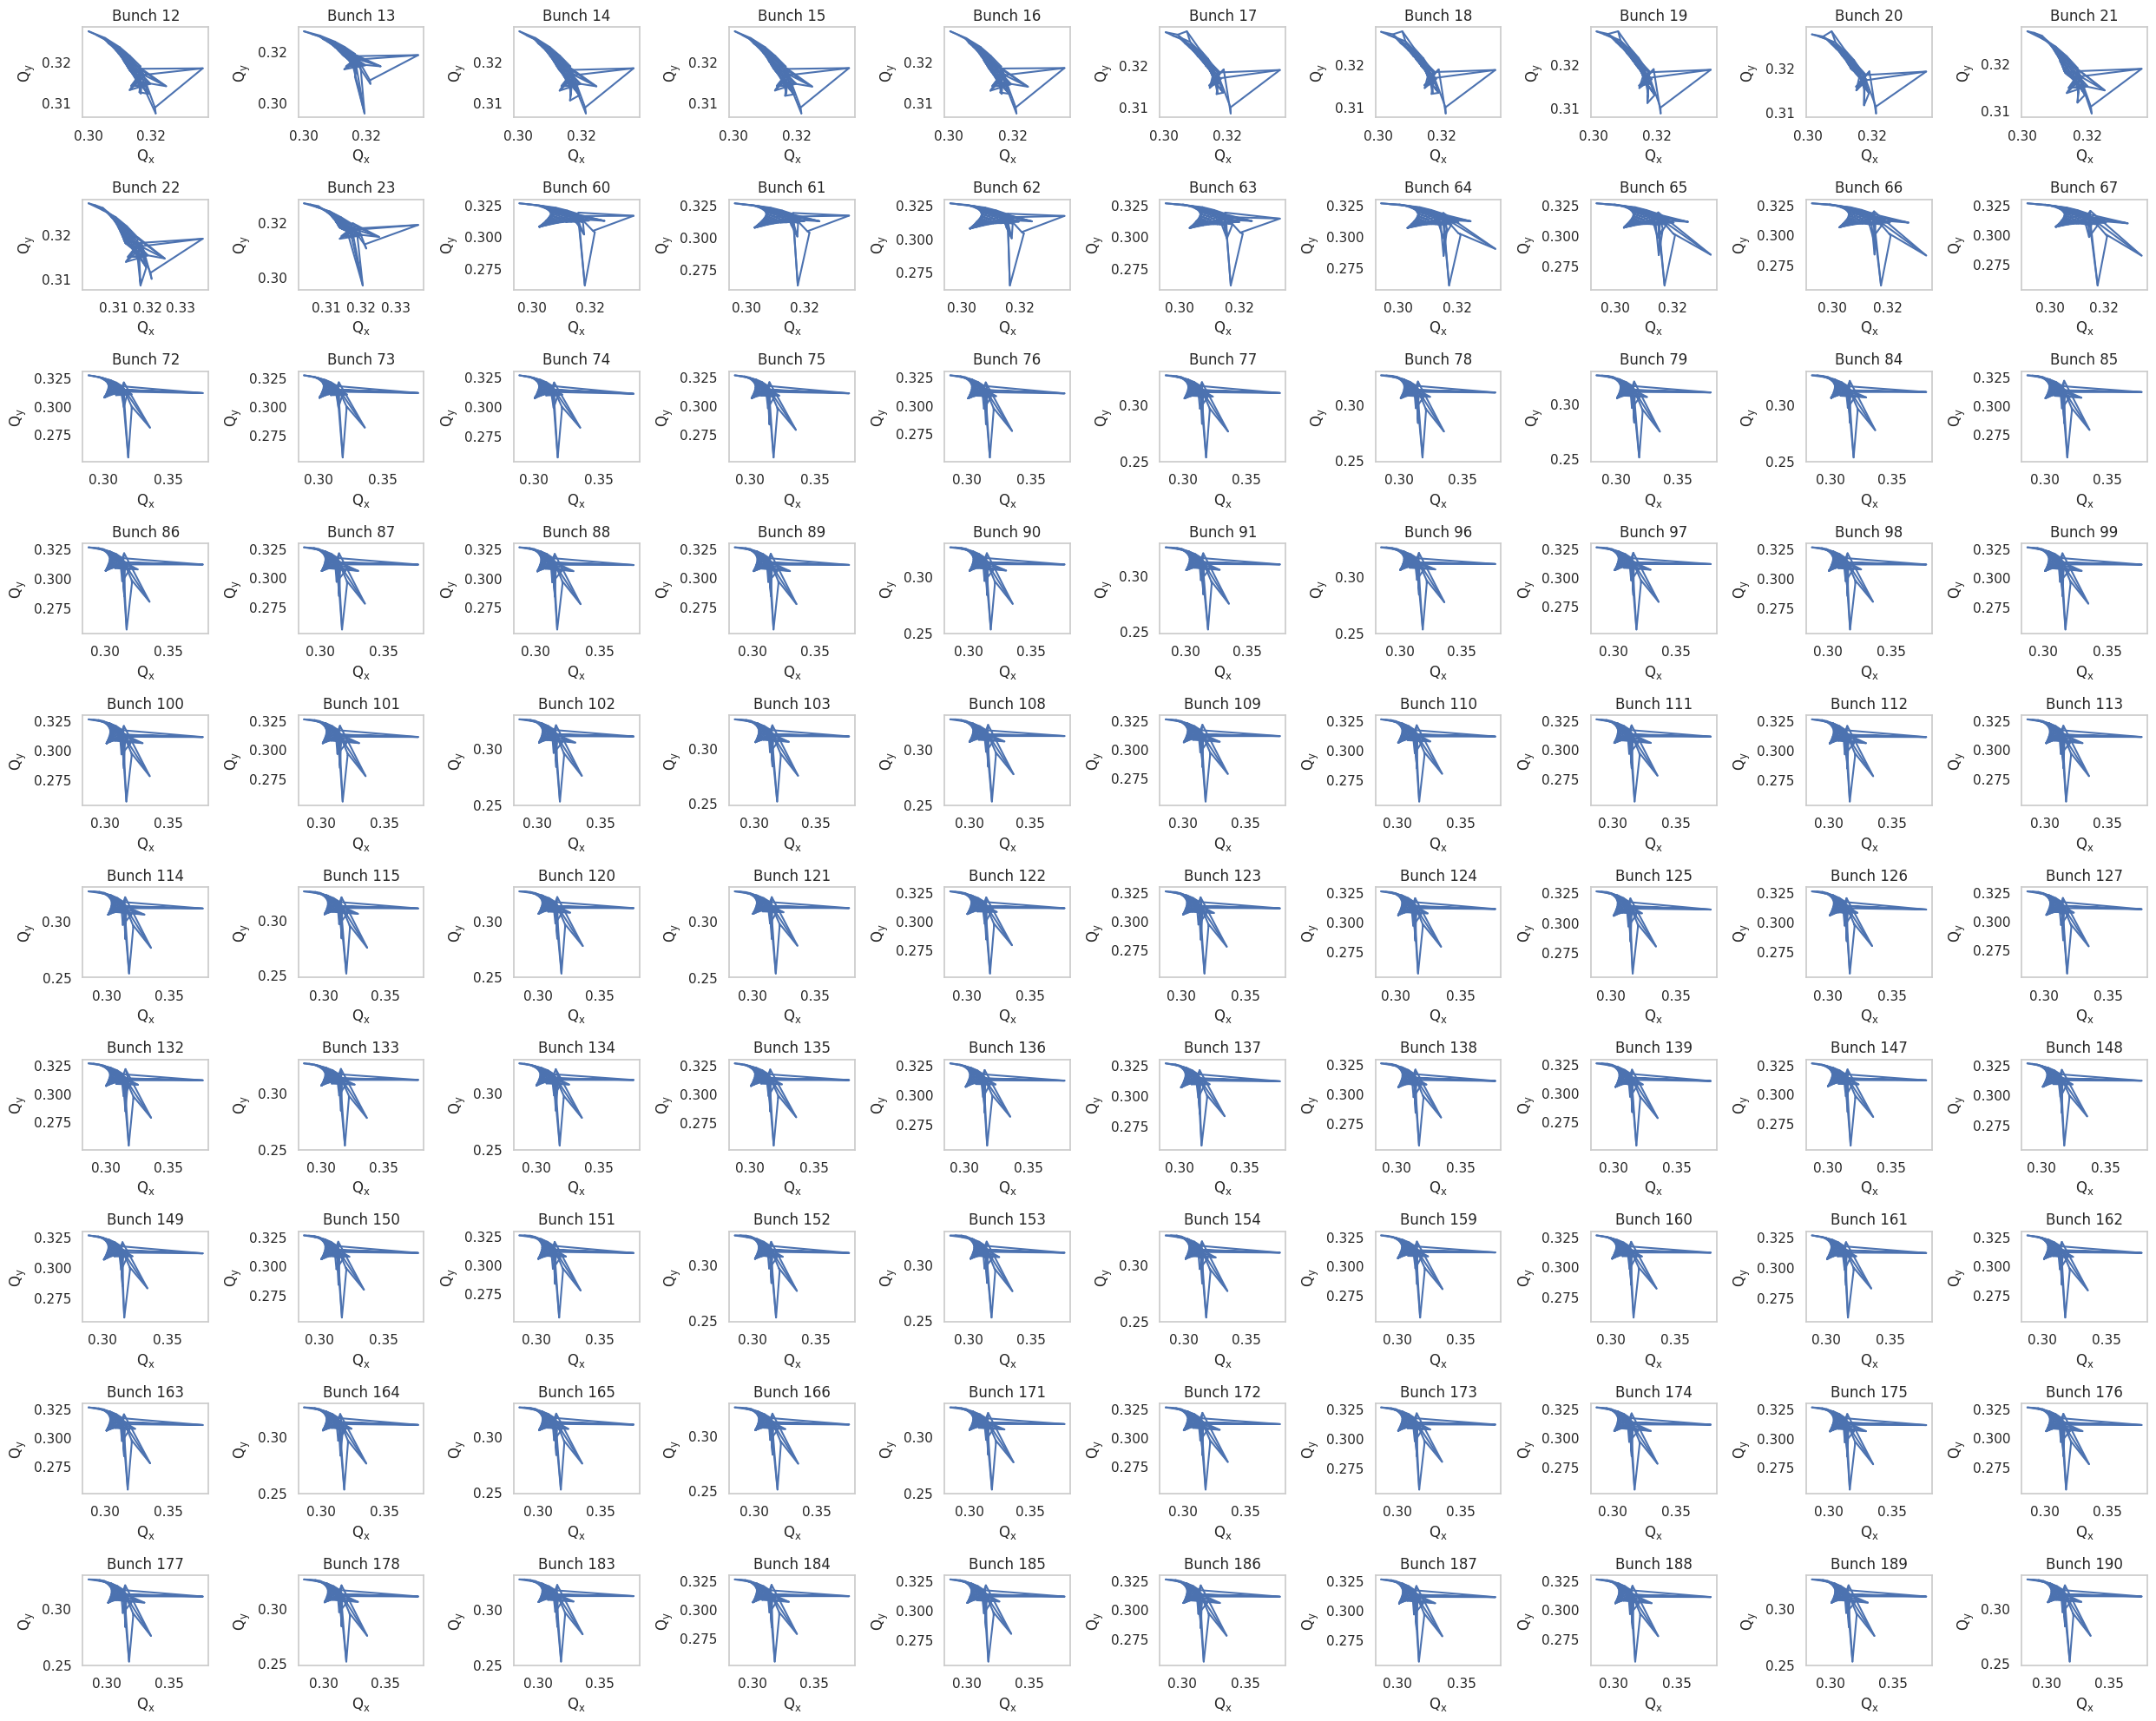

In [22]:
# Load l_fp
with open("output_2/l_fp.pkl", "rb") as f:
    l_fp = pickle.load(f)[:100]

# Load list of bunch numbers
with open("output_2/l_bunch_nb.pkl", "rb") as f:
    l_bunch_nb = pickle.load(f)[:100]

# Make a grid of plots for all the footprints
n_cols = 10
n_rows = int(np.ceil(len(l_fp)/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
for i, fp in enumerate(l_fp):
    try:
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp[0], fp[1], color="C0")
        ax.plot(fp[0].T, fp[1].T, color="C0")
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.set_xlabel(r"$\mathrm{Q_x}$")
        ax.set_ylabel(r"$\mathrm{Q_y}$")
        #ax.set_xlim(0, 1)
        #ax.set_ylim(0, 1)
        ax.grid()
        #ax.set_aspect("equal")
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
    except:
        pass

plt.tight_layout()
plt.show()

